# Statistics

11/02/2019

use the data tables 


In [15]:
# import rpy2.robjects.lib.ggplot2 as ggplot2
# from rpy2.robjects import r, pandas2ri
# pandas2ri.activate()

# import rpy2.robjects.packages as importr

# %load_ext rpy2.ipython

In [1]:
import pandas as pd
from plotnine import *

import networkx as nx
import random
import numpy as np
import os, sys, glob
from collections import defaultdict, Counter
import ast
import itertools
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats



import matplotlib.pyplot as plt

In [2]:
output_dir = 'diffloop_data/bedpe_files_csvs/'
output_dir_LK = 'diffloop_data/bedpe_files_csvs_LK/'

#### MODIFY WHEN NEW DATA COMES
output_dir = output_dir_LK


tissues = ['Air',
 'Astro',
 'Blad',
 'Colon',
 'Eso',
 'GDSD0',
 'GDSD3',
 'GDSD6',
 'GM12878',
 'HMEC',
 'MC',
 'Ova',
 'Panc',
 'Pros',
 'Renal',
 'Thy',
 'Uter']
type_prefix='-5000-separate'

In [3]:
# df1 = pd.read_csv(os.path.join(output_dir, 'MC'+type_prefix+'-merged.anchors.csv'),index_col=0)
# df2 = pd.read_csv(os.path.join(output_dir_LK, "MC"+type_prefix+'-merged.anchors.csv'),index_col=0)
# df1 = df1.merge(df2, on=['anchors', 'chr', 'start', 'end', 'sample', 'atac_regions', 'num_atac_regions', 'snp', 'num_snp'])
# print(df1.shape)
# df1[(df1['gene_x']!=df1['gene_y']) & (df1[['gene_x','gene_y']].notna().all(axis=1))]

In [4]:
# df1[df1[['gene_x','gene_y']].notna().all(axis=1)][['gene_x', 'gene_y']]

In [5]:
# (df1['gene_x']!=df1['gene_y'])

In [6]:
# anchor_tissue_dict[tissue][:6]

In [7]:
anchor_tissue_dict = {}
anchor_tissue_dict_TSS = {}
anchor_tissue_dict = {}
hichip_tissue_dict={}

for tissue in tissues: 
    df = pd.read_csv(os.path.join(output_dir, tissue+type_prefix+'-merged.anchors.csv'),index_col=0)
    print(tissue, df.shape)
#     df = pd.read_csv(os.path.join(output_dir_LK, tissue+type_prefix+'-merged.anchors.csv'),index_col=0)
    anchor_tissue_dict[tissue] = df
        

for tissue in tissues: 
    df = pd.read_csv(os.path.join(output_dir, tissue+type_prefix+'-merged.loops.csv'),index_col=0)
    print(tissue, df.shape)
    hichip_tissue_dict[tissue] = df


Air (26056, 11)
Astro (97103, 11)
Blad (93584, 11)
Colon (101559, 11)
Eso (90014, 11)
GDSD0 (98754, 11)
GDSD3 (102648, 11)
GDSD6 (88943, 11)
GM12878 (83619, 11)
HMEC (71426, 11)
MC (63043, 11)
Ova (89008, 11)
Panc (61609, 11)
Pros (136934, 11)
Renal (116247, 11)
Thy (87756, 11)
Uter (168205, 11)
Air (29646, 3)
Astro (194682, 3)
Blad (180684, 3)
Colon (226720, 3)
Eso (213658, 3)
GDSD0 (170716, 3)
GDSD3 (187809, 3)
GDSD6 (170366, 3)
GM12878 (167347, 3)
HMEC (110176, 3)
MC (82124, 3)
Ova (178829, 3)
Panc (99357, 3)
Pros (265992, 3)
Renal (223889, 3)
Thy (173987, 3)
Uter (399576, 3)


In [8]:
# overall_snp_df = pd.DataFrame([])
# for tissue,df in sorted(hichip_tissue_dict.items(), key=lambda x:x[0]):
#     print(tissue)
overall_stats_dict = {}
for tissue in tissues:
# tissue = 'MC'
    tissue_stats_dict = {}
    anchors_df = anchor_tissue_dict[tissue]
    df = hichip_tissue_dict[tissue]

    print(tissue)
#     print(anchors_df.columns)
    anchors_df['is_acc']= anchors_df['num_atac_regions']>0
    if 'num_TSS' in anchors_df.columns:
        anchors_df['is_promoter'] = anchors_df['num_TSS']>0
    else:
        anchors_df['is_promoter'] = anchors_df['num_gene']>0
        
    anchors_df['is_promoter_acc'] = anchors_df['is_promoter'] & anchors_df['is_acc']

    # Loose defintion: frac_PIR + frac_P = 1
    anchors_df['is_PIR'] = ~anchors_df['is_promoter']
    # IF YOU WANT NON-INTERGENIC REGIONS THEN USE PIR_STRICT DEFINITION (NOT USED) - must have latest file version
    # in this case some promoters are also annotated as genomic regions in Gencode so frac_PIR + frac_P + frac_gene > 1
    # anchors_df['is_intergene'] = anchors_df['num_gene']>0
    # anchors_df['is_intergene_acc'] = anchors_df['is_intergene'] & anchors_df['is_acc']
    
    # anchors_df['is_PIR_strict'] = (~anchors_df['is_promoter']) & (~anchors_df['is_intergene']) 
    anchors_df['is_PIR_acc'] = anchors_df['is_PIR'] & anchors_df['is_acc']

    for c in anchors_df[['is_acc', 'is_promoter', 'is_promoter_acc','is_PIR', 'is_PIR_acc'
                            ## UNCOMMENT IF CARE ABOUT INTERGENE DIFFERENTIATION
#                          ,'is_intergene','is_intergene_acc'
                        ]].columns:
#         print( "---- %s ---" % c)
#         print (anchors_df[c].value_counts(normalize=True)[True])
        tissue_stats_dict[c] = anchors_df[c].value_counts(normalize=True)[True]

    tissue_stats_dict['num_loops']=df.shape[0]
    df_annon = df.merge(anchors_df,left_on='source', right_on='anchors')
    df_annon = df_annon.merge(anchors_df,left_on='target', right_on='anchors',suffixes=["_A","_B"])
#     df_annon['min_atac'] = df_annon[['num_atac_regions_A','num_atac_regions_B']].min(axis=1)
#     df_annon['sum_snps'] = df_annon['num_snp_A'] + df_annon['num_snp_B']
#     df_annon['sum_gene'] = df_annon['num_gene_A'] + df_annon['num_gene_B']
#     df_annon['sum_TSS'] = df_annon['num_TSS_A'] + df_annon['num_TSS_B']
#     df_annon['tissue'] = tissue

    # df_annon ATAC PERCENTAGES
    df_annon['loop_is_both_acc'] = df_annon['is_acc_A'] & df_annon['is_acc_B']
    df_annon['loop_is_one_acc'] = df_annon['is_acc_A'] | df_annon['is_acc_B']
    # df_annon['loop_is_not_acc'] = ~df_annon['loop_is_one_acc'] 
    df_annon['loop_PIR_PIR'] = df_annon['is_PIR_A'] & df_annon['is_PIR_B']
    df_annon['loop_PIR_PIR_acc'] = df_annon['loop_PIR_PIR'] & df_annon['is_acc_A'] & df_annon['is_acc_B']
    df_annon['loop_P_PIR'] = (df_annon['is_PIR_A'] & df_annon['is_promoter_B']) | (df_annon['is_PIR_B'] & df_annon['is_promoter_A'])
    df_annon['loop_P_PIR_acc'] = df_annon['loop_P_PIR'] & df_annon['is_acc_A'] & df_annon['is_acc_B']
    df_annon['loop_P_P'] = df_annon['is_promoter_A'] & df_annon['is_promoter_B']
    df_annon['loop_P_P_acc'] = df_annon['loop_P_P'] & df_annon['is_acc_A'] & df_annon['is_acc_B']
    ## UNCOMMENT IF CARE ABOUT INTERGENE DIFFERENTIATION
#     df_annon['loop_P_P_gene_TSS'] = (df_annon['is_promoter_A'] | df_annon['is_intergene_A']) & (df_annon['is_promoter_B'] | df_annon['is_intergene_B'])
#     df_annon['loop_P_P_gene_TSS_acc'] = df_annon['loop_P_P_gene_TSS'] & df_annon['is_acc_A'] & df_annon['is_acc_B']
#     df_annon['loop_P_PIR_gene_TSS'] = ((df_annon['is_promoter_A'] | df_annon['is_intergene_A']) & df_annon['is_PIR_B']) | \
#                                             ((df_annon['is_promoter_B'] | df_annon['is_intergene_B']) & df_annon['is_PIR_A'])
#     df_annon['loop_P_PIR_gene_TSS_acc'] = df_annon['loop_P_PIR_gene_TSS'] & df_annon['is_acc_A'] & df_annon['is_acc_B']

    for c in df_annon[['loop_is_both_acc',
           'loop_is_one_acc', 'loop_PIR_PIR',
           'loop_PIR_PIR_acc', 'loop_P_PIR', 'loop_P_PIR_acc', 'loop_P_P',
           'loop_P_P_acc'
                    ## UNCOMMENT IF CARE ABOUT INTERGENE DIFFERENTIATION
#                        , 'loop_P_P_gene_TSS', 'loop_P_P_gene_TSS_acc', 
#                       'loop_P_PIR_gene_TSS', 'loop_P_PIR_gene_TSS_acc'
                      ]].columns:
#         print( "---- %s ---" % c)
#         print (df_annon[c].value_counts(normalize=True)[True])
        tissue_stats_dict[c] = df_annon[c].value_counts(normalize=True)[True]

    # df_annon_filt = df_annon[(df_annon.sum_gene>0) & (df_annon.sum_snps>0) ]
    #     print(tissue, df_annon_filt.shape)#, overall_snp_df.shape)
    #     if overall_snp_df.shape[0]==0:
    #         overall_snp_df = df_annon_filt
    #     else:
    #         overall_snp_df = pd.concat([overall_snp_df, df_annon_filt], ignore_index=True)
    # print(tissue_stats_dict)
#     df_annon[:5]
    overall_stats_dict[tissue]=tissue_stats_dict


Air
Astro
Blad
Colon
Eso
GDSD0
GDSD3
GDSD6
GM12878
HMEC
MC
Ova
Panc
Pros
Renal
Thy
Uter


In [9]:
overall_stats_df = pd.DataFrame.from_dict(overall_stats_dict,orient='index')
overall_stats_df_select = overall_stats_df[['loop_P_P_acc', 'loop_P_PIR_acc', 'loop_PIR_PIR_acc']]

In [10]:
# # overall_stats_df.to_csv('looping_stats.csv') 
# # display(overall_stats_df)
# with open('networks/looping_stats_1107.csv', 'w') as f:
#     header=','.join(['tissue']+list(overall_stats_df.columns))+'\n'
#     f.write(header)
#     for idx,line in overall_stats_df.iterrows(): 
#         new_line = ','.join([idx]+[str(x) for x in line])+'\n'
#         f.write(new_line)

In [11]:
overall_stats_df.to_csv('networks/looping_stats_1107.csv')

In [12]:
overall_stats_df_select['tissue'] = overall_stats_df_select.index
overall_stats_df_select_long = pd.melt(overall_stats_df_select,id_vars='tissue')

/Users/margaret/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
overall_stats_df_select_long[:5]

,tissue,variable,value
0,Air,loop_P_P_acc,0.020542
1,Astro,loop_P_P_acc,0.009698
2,Blad,loop_P_P_acc,0.019172
3,Colon,loop_P_P_acc,0.038700
4,Eso,loop_P_P_acc,0.039774


/Users/margaret/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/margaret/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/margaret/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/margaret/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was de

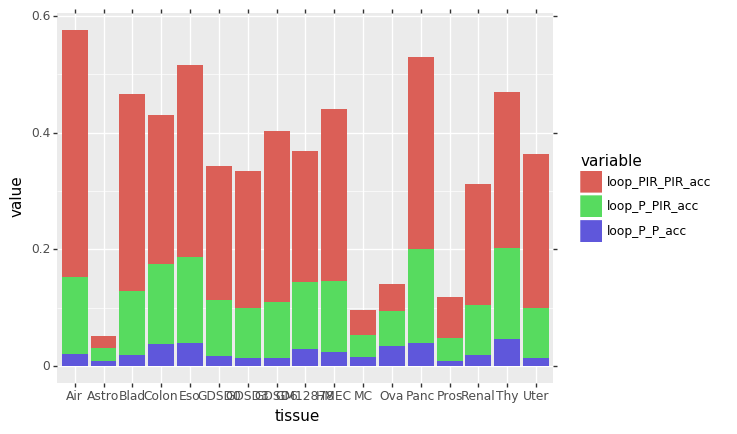

<ggplot: (343739554)>

In [14]:
(ggplot(overall_stats_df_select_long, aes(x='tissue', y='value',fill='variable'))
 + geom_bar(stat = "identity")
#  + geom_text(
#      aes(label='stat(count)'),
#      stat='count',
#      nudge_y=0.125,
#      va='bottom'
#  )
)

In [130]:
df_annon.columns


Index(['source', 'target', 'count', 'anchors_A', 'chr_A', 'start_A', 'end_A',
       'sample_A', 'snp_A', 'num_snp_A', 'TSS_A', 'num_TSS_A', 'gene_A',
       'num_gene_A', 'atac_regions_A', 'num_atac_regions_A', 'motif_A',
       'num_motif_A', 'is_acc_A', 'is_promoter_A', 'is_promoter_acc_A',
       'is_intergene_A', 'is_intergene_acc_A', 'is_PIR_A', 'is_PIR_acc_A',
       'anchors_B', 'chr_B', 'start_B', 'end_B', 'sample_B', 'snp_B',
       'num_snp_B', 'TSS_B', 'num_TSS_B', 'gene_B', 'num_gene_B',
       'atac_regions_B', 'num_atac_regions_B', 'motif_B', 'num_motif_B',
       'is_acc_B', 'is_promoter_B', 'is_promoter_acc_B', 'is_intergene_B',
       'is_intergene_acc_B', 'is_PIR_B', 'is_PIR_acc_B', 'min_atac',
       'sum_snps', 'sum_gene', 'sum_TSS', 'tissue', 'loop_is_both_acc',
       'loop_is_one_acc', 'loop_is_not_acc', 'loop_PIR_PIR',
       'loop_PIR_PIR_acc', 'loop_P_PIR', 'loop_P_PIR_acc', 'loop_P_P',
       'loop_P_P_acc', 'loop_P_P_gene_TSS', 'loop_P_P_gene_TSS_acc'],
   

In [125]:
0.094126+0.604223+0.36261

1.060959

In [124]:
for c in anchors_df[['is_acc', 'is_promoter', 'is_promoter_acc','is_intergene','is_intergene_acc','is_PIR', 'is_PIR_acc']].columns:
    print( "---- %s ---" % c)
    print (anchors_df[c].value_counts(normalize=True))

---- is_acc ---
False    0.818061
True     0.181939
Name: is_acc, dtype: float64
---- is_promoter ---
False    0.905874
True     0.094126
Name: is_promoter, dtype: float64
---- is_promoter_acc ---
False    0.926907
True     0.073093
Name: is_promoter_acc, dtype: float64
---- is_intergene ---
True     0.604223
False    0.395777
Name: is_intergene, dtype: float64
---- is_intergene_acc ---
False    0.886887
True     0.113113
Name: is_intergene_acc, dtype: float64
---- is_PIR ---
False    0.63739
True     0.36261
Name: is_PIR, dtype: float64
---- is_PIR_acc ---
False    0.956173
True     0.043827
Name: is_PIR_acc, dtype: float64


# old version

In [61]:
# def is_acc(node,g):
#     if g.nodes[node]['atac'] == ['atac_peak']:
#         return True
#     return False
    
# def is_PIR(node, g, acc=True):
#     if len(g.nodes[node]['genes'])==0 and len(g.nodes[node]['promoter'])==0:
#         if acc:
#             if is_acc(node,g):
#                 return True
#             else:
#                 return False
#         else:
#             return True
#     return False

# def is_promoter(node,g,acc=True):
#     if len(g.nodes[node]['promoter'])>0 or len(g.nodes[node]['genes'])>0 :
#         if acc:
#             if is_acc(node,g):
#                 return True
#             else:
#                 return False
#         else:
#             return True
#     return False


In [60]:
# network_pickle_dir = 'networks/'
# for gpickle_file in glob.glob(os.path.join(network_pickle_dir, '*gpickle')):
#     tissue = gpickle_file.split('/')[-1].split('.')[0]
# #     print(tissue)
#     g = nx.read_gpickle(gpickle_file)  
#     atac_bool = nx.get_node_attributes(g, 'is_atac')
#     atac_bool = nx.get_node_attributes(g, 'is_atac')
   
#     num_loops_P_P_acc, num_loops_P_PIR_acc, num_loops_PIR_PIR_acc, num_loops_other_acc = 0,0,0,0
#     num_loops_P_P, num_loops_P_PIR, num_loops_PIR_PIR, num_loops_other = 0,0,0,0
#     num_loops = len(g.edges())
#     num_loops_both_acc, num_loops_one_acc, num_loops_not_acc= 0,0,0
    
#     for node_1, node_2 in g.edges:
#         node_1_acc = is_acc(node_1, g)
#         node_2_acc = is_acc(node_2, g)
#         if node_1_acc and node_2_acc:
#             num_loops_both_acc+=1
#         elif node_1_acc or node_2_acc:
#             num_loops_one_acc+=1
#         else:
#             num_loops_not_acc+=1
        
#         node_1_P_acc = is_promoter(node_1, g)
#         node_2_P_acc = is_promoter(node_2, g)
#         node_1_PIR_acc = is_PIR(node_1, g)
#         node_2_PIR_acc = is_PIR(node_2, g)
#         if node_1_P_acc and node_2_P_acc:
#             num_loops_P_P_acc+=1
#         elif (node_1_P_acc and node_2_PIR_acc) or (node_1_PIR_acc and node_2_P_acc):
#             num_loops_P_PIR_acc+=1
#         elif node_1_PIR_acc and node_2_PIR_acc:
#             num_loops_PIR_PIR_acc+=1
#         else:
#             num_loops_other_acc+=1

            
#         node_1_P = is_promoter(node_1, g, acc=False)
#         node_2_P = is_promoter(node_2, g, acc=False)
#         node_1_PIR = is_PIR(node_1, g, acc=False)
#         node_2_PIR = is_PIR(node_2, g, acc=False)
#         if node_1_P and node_2_P:
#             num_loops_P_P+=1
#         elif (node_1_P and node_2_PIR) or (node_1_PIR and node_2_P):
#             num_loops_P_PIR+=1
#         elif node_1_PIR and node_2_PIR:
#             num_loops_PIR_PIR+=1
#         else:
#             num_loops_other+=1
# #     print('num_loops', num_loops) 
    



#     print('\t'.join([tissue, str(num_loops)]+['%d' % x for x in [num_loops_P_P, num_loops_P_PIR, num_loops_PIR_PIR, num_loops_other,num_loops_both_acc, num_loops_one_acc, num_loops_not_acc, num_loops_P_P_acc, num_loops_P_PIR_acc, num_loops_PIR_PIR_acc, num_loops_other_acc]]))
# #     print('\t'.join([tissue, str(num_loops)]+['%.3f' % (x/float(num_loops)) for x in [num_loops_P_P, num_loops_P_PIR, num_loops_PIR_PIR, num_loops_other,num_loops_both_acc, num_loops_one_acc, num_loops_not_acc]]))
# #     print([num_loops_P_P, num_loops_P_PIR, num_loops_PIR_PIR, num_loops_other,num_loops_both_acc, num_loops_one_acc, num_loops_not_acc])
#     #     print('\t'.join(['%.2f'% (x/float(num_loops)) for x  in [num_loops_both_acc, num_loops_one_acc, num_loops_not_acc]]))
    

# #     promoter_bool = nx.get_node_attributes(g, 'promoter')
# #     motifs = nx.get_node_attributes(g, 'footprint')

In [58]:
#  g.nodes['chr1,16005000,16010000']

In [59]:
# g.nodes['chr1,203485000,203490000']

In [57]:
# for node_1, node_2 in list(g.edges)[:100]:
#     node_1_P_acc = is_promoter(node_1, g)
#     node_2_P_acc = is_promoter(node_2, g)
#     node_1_PIR_acc = is_PIR(node_1, g)
#     node_2_PIR_acc = is_PIR(node_2, g)    
#     print(node_1_P_acc, node_2_P_acc, node_1_PIR_acc, node_2_PIR_acc)

# Q2 - what are cell type specific anchor points


In [17]:
anchors_binary_per_tissue = {}
for tissue in tissues:
    print(tissue)
    anchors_df = anchor_tissue_dict[tissue]
#     df = hichip_tissue_dict[tissue]
    for anchor in anchors_df.anchors:
        if anchor in anchors_binary_per_tissue:
            anchors_binary_per_tissue[anchor][tissue]=1
        else:
            anchors_binary_per_tissue[anchor] = {tissue:1}


Air
Astro
Blad
Colon
Eso
GDSD0
GDSD3
GDSD6
GM12878
HMEC
MC
Ova
Panc
Pros
Renal
Thy
Uter


In [22]:
anchors_binary_per_tissue_df = pd.DataFrame.from_dict(anchors_binary_per_tissue,orient='index')

In [24]:
anchors_binary_per_tissue_df.fillna(0,inplace=True)

In [45]:
anchors_binary_per_tissue_df[:5]

,Air,Astro,Colon,Eso,GDSD6,Ova,Panc,Pros,Renal,Thy,HMEC,MC,Blad,GDSD0,GDSD3,Uter,GM12878
chr10_100000000_100005000,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
chr10_100005000_100010000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
chr10_100010000_100015000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
chr10_100015000_100020000,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
chr10_100020000_100025000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [29]:
anchors_binary_per_tissue_df.shape

(286925, 17)

In [49]:
anchors_binary_per_tissue_df.to_csv('networks/anchors_binary_per_tissue_df.csv')

In [57]:
# distribution of unique anchors by cell type
anchors_unique_tissue_long_df = anchors_binary_per_tissue_df[anchors_binary_per_tissue_df.sum(axis=1)==1].reset_index().melt(id_vars='index')
anchors_unique_tissue_long_df = anchors_unique_tissue_long_df[anchors_unique_tissue_long_df.value==1.0]
anchors_unique_tissue_long_df.variable.value_counts()

Uter       19610
GM12878     8557
Pros        8275
Astro       6877
Renal       6517
GDSD3       3689
Colon       2995
GDSD6       2986
GDSD0       2899
MC          2720
Blad        2351
Eso         2111
Thy         1733
Ova         1671
HMEC        1016
Panc         725
Air           47
Name: variable, dtype: int64

In [28]:
anchors_binary_per_tissue_df.sum(axis=1).value_counts()

1.0     74779
2.0     39423
3.0     26813
4.0     20503
5.0     16566
6.0     13949
7.0     12188
8.0     10886
9.0      9845
10.0     8672
16.0     8241
11.0     8096
15.0     7642
12.0     7414
17.0     7398
14.0     7273
13.0     7237
dtype: int64

In [30]:
74779/286925

0.260622113792803

In [46]:
7237/286925

0.02522261915134617

About 26% of anchors are cell type specific at a 5Kb resolution

2.5% of anchors are in all cell types at a 5Kb resolution

In [34]:
unique_anchors = list(anchors_binary_per_tissue_df.index[anchors_binary_per_tissue_df.sum(axis=1)==1])


# Q3 - what are cell type specific looping (two points

In [40]:
loops_binary_per_tissue = {}
for tissue in tissues:
    print(tissue)
    hichip_df = hichip_tissue_dict[tissue]
    for loop_tuple in zip(hichip_df.source, hichip_df.target):
        loop_str = '::'.join(loop_tuple)
        if loop_str in loops_binary_per_tissue:
            loops_binary_per_tissue[loop_str][tissue]=1
        else:
            loops_binary_per_tissue[loop_str] = {tissue:1}


Air
Astro
Blad
Colon
Eso
GDSD0
GDSD3
GDSD6
GM12878
HMEC
MC
Ova
Panc
Pros
Renal
Thy
Uter


In [41]:
loops_binary_per_tissue_df = pd.DataFrame.from_dict(loops_binary_per_tissue,orient='index')
loops_binary_per_tissue_df.fillna(0,inplace=True)

In [42]:
loops_binary_per_tissue_df.shape

(1130691, 17)

In [4]:
loops_binary_per_tissue_df = pd.read_csv('networks/loops_binary_per_tissue_df.csv', index_col=0)

In [5]:
loops_binary_per_tissue_df.sum(axis=1).value_counts()

1.0     601390
2.0     181379
3.0      94607
4.0      61362
5.0      43232
6.0      32948
7.0      25407
8.0      19602
9.0      15228
10.0     12038
11.0      9869
12.0      8357
13.0      7197
14.0      6302
15.0      5296
16.0      3985
17.0      2492
dtype: int64

In [6]:
601390/1130691

0.5318782938928496

In [7]:
2492/1130691

0.0022039620019970087

53% of loops are cell type specific at a 5Kb resolution

.2% of loops are in all cell types at a 5Kb resolution

In [8]:
unique_loops = list(loops_binary_per_tissue_df.index[loops_binary_per_tissue_df.sum(axis=1)==1])


In [10]:
# unique_loops

In [11]:
# distribution of unique loops by cell type
loops_unique_tissue_long_df = loops_binary_per_tissue_df[loops_binary_per_tissue_df.sum(axis=1)==1].reset_index().melt(id_vars='index')
loops_unique_tissue_long_df = loops_unique_tissue_long_df[loops_unique_tissue_long_df.value==1.0]
loops_unique_tissue_long_df.variable.value_counts()

Uter       129389
GM12878     75918
Astro       57560
Renal       50168
Pros        48975
Eso         36144
Colon       35205
GDSD6       28345
GDSD3       27723
Blad        22455
GDSD0       19844
Thy         18771
Ova         18379
MC          16928
HMEC         7980
Panc         7006
Air           600
Name: variable, dtype: int64

In [ ]:
loops_unique_tissue_long_df.to_csv('networks/loops_unique_tissue_long_df.csv')

In [78]:
# shared vs unique loops per tissue
loops_share_unique = pd.DataFrame({'total_loops':loops_binary_per_tissue_df.sum(axis=0),
                                   'unique_loops':loops_unique_tissue_long_df.variable.value_counts()})
loops_share_unique['shared_loops']=loops_share_unique.total_loops - loops_share_unique.unique_loops
loops_share_unique=loops_share_unique[['shared_loops','unique_loops']]
loops_share_unique['tissue'] = loops_share_unique.index
loops_share_unique = loops_share_unique.melt(id_vars='tissue')
display(loops_share_unique[:5])


,tissue,variable,value
0,Air,shared_loops,29046.0
1,Astro,shared_loops,137122.0
2,Blad,shared_loops,158229.0
3,Colon,shared_loops,191515.0
4,Eso,shared_loops,177514.0


In [81]:
loops_share_unique.to_csv('networks/loops_share_unique.csv')

/Users/margaret/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/margaret/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/margaret/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/margaret/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was de

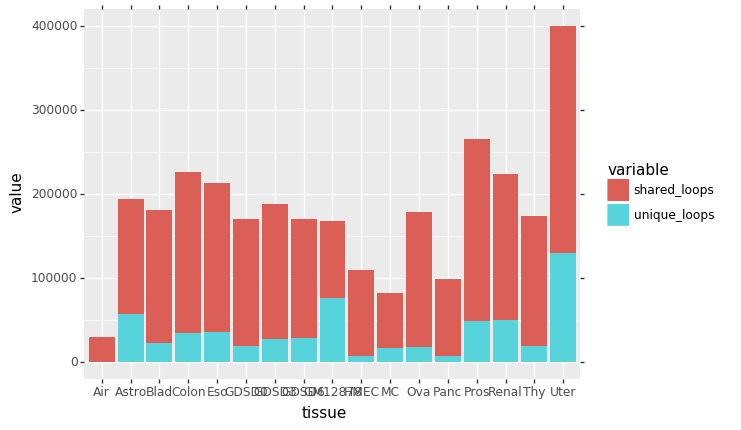

<ggplot: (-9223372036498638904)>

In [80]:
(ggplot(loops_share_unique, aes(x='tissue', y='value',fill='variable'))
 + geom_bar(stat = "identity"))


In [50]:
loops_binary_per_tissue_df.to_csv('networks/loops_binary_per_tissue_df.csv')

In [62]:
loops_unique_tissue_long_df.variable.value_counts().index

Index(['Uter', 'GM12878', 'Astro', 'Renal', 'Pros', 'Eso', 'Colon', 'GDSD6',
       'GDSD3', 'Blad', 'GDSD0', 'Thy', 'Ova', 'MC', 'HMEC', 'Panc', 'Air'],
      dtype='object')

In [63]:
'::'.join(list(loops_unique_tissue_long_df.variable.value_counts().index))

'Uter::GM12878::Astro::Renal::Pros::Eso::Colon::GDSD6::GDSD3::Blad::GDSD0::Thy::Ova::MC::HMEC::Panc::Air'